In [1]:
try:
    import opendatasets as od
except ImportError:
    !pip install opendatasets
    import opendatasets as od  # Import again after installation

# Download the dataset
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: detayotella
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces


100%|██████████| 696M/696M [00:05<00:00, 126MB/s]


In [2]:
import os
import torch
import torch.nn as nn
from torchvision import transforms
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import pandas as pd
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device available: {device}")

Device available: cuda


In [3]:
image_path: list[str] = []
labels: list[str] = []

for i in os.listdir("/content/animal-faces/afhq"):
    for label in os.listdir(f"/content/animal-faces/afhq/{i}"):
        for image in os.listdir(f"/content/animal-faces/afhq/{i}/{label}"):
            image_path.append(f"/content/animal-faces/afhq/{i}/{label}/{image}")
            labels.append(label)


data_df = pd.DataFrame(zip(image_path, labels), columns=["image_path", "labels"])

print(data_df["labels"].nunique())
data_df.head()

3


,image_path,labels
0,/content/animal-faces/afhq/val/wild/flickr_wil...,wild
1,/content/animal-faces/afhq/val/wild/flickr_wil...,wild
2,/content/animal-faces/afhq/val/wild/flickr_wil...,wild
3,/content/animal-faces/afhq/val/wild/flickr_wil...,wild
4,/content/animal-faces/afhq/val/wild/flickr_wil...,wild


In [4]:
train = data_df.sample(frac=0.7)
test = data_df.drop(train.index)

val = test.sample(frac=0.7)
test = test.drop(val.index)

print(train.shape)
print(val.shape)
print(test.shape)

(11291, 2)
(3387, 2)
(1452, 2)


In [5]:
label_encoder = LabelEncoder()
label_encoder.fit(data_df["labels"])

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame,
                 transform: transforms.Compose=None) -> None:
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(label_encoder.transform(dataframe["labels"])).to(device)

    def __len__(self):
        return self.dataframe.shape[0]


    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.labels[idx]

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image).to(device)

        return image, label


In [7]:
train_dataset = CustomImageDataset(dataframe=train, transform=transform)
val_dataset = CustomImageDataset(dataframe=val, transform=transform)
test_dataset = CustomImageDataset(dataframe=test, transform=transform)

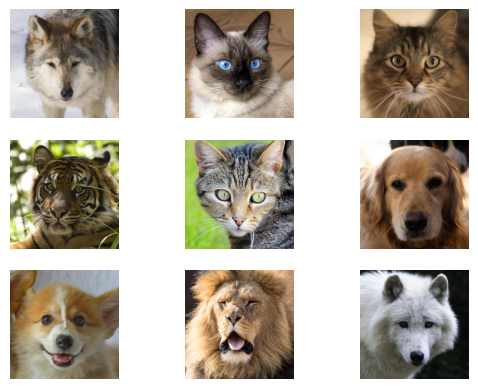

In [8]:
import matplotlib.pyplot as plt

n_rows = 3
n_cols = 3

f, axarr = plt.subplots(n_rows, n_cols)



for row in range(n_rows):
    for col in range(n_cols):
        image = Image.open(data_df.sample(n=1)["image_path"].iloc[0]).convert("RGB")
        axarr[row, col].imshow(image)
        axarr[row, col].axis("off")

plt.show()

In [9]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10

In [10]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [11]:
num_classes = len(data_df["labels"].unique())

class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.pooling = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

        self.flatten = nn.Flatten()
        self.linear = nn.Linear((128 * 16 * 16), 128)

        self.output = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)   # -> (32, 128, 128)
        x = self.pooling(x) # -> (32, 64, 64)
        x = self.relu(x)

        x = self.conv2(x)   # -> (64, 64, 64)
        x = self.pooling(x) # -> (64, 32, 32)
        x = self.relu(x)

        x = self.conv3(x)   # -> (128, 32, 32)
        x = self.pooling(x) # -> (128, 16, 16)
        x = self.relu(x)

        x = self.flatten(x)
        x = self.linear(x)
        x = self.output(x)
        return x


In [12]:
model = Net(num_classes).to(device)

In [13]:
from torchsummary import summary

summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

In [14]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.MaxPool2d(2, 2), # Output: (32, 64, 64)
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.MaxPool2d(2, 2),  # Output: (64, 32, 32)
            nn.ReLU(),


            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.MaxPool2d(2, 2),  # Output: (128, 16, 16)
            nn.ReLU(),

        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 128),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

model = Net(num_classes).to(device)

In [15]:
from torchsummary import summary

summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [17]:
total_loss_train_plot = []
total_loss_val_plot = []
total_acc_train_plot = []
total_acc_val_plot = []

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_acc_val = 0
    total_loss_train = 0
    total_loss_val = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad() # This can be put at the end or the beginning

        outputs = model(inputs)
        train_loss = criterion(outputs, labels)
        total_loss_train += train_loss.item()

        train_loss.backward()

        train_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()

        total_acc_train += train_acc
        optimizer.step()


    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            total_loss_val += val_loss.item()

            val_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
            total_acc_val += val_acc



    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_val_plot.append(round(total_loss_val/1000, 4))

    total_acc_train_plot.append(round(total_acc_train/train_dataset.__len__() * 100, 4))
    total_acc_val_plot.append(round(total_acc_val/val_dataset.__len__() * 100, 4))


    print(f"""Epoch no. {epoch+1} Train Loss: {round(total_loss_train/1000, 4)} Train Accuracy: {round(total_acc_train/train_dataset.__len__() * 100, 4)}
          Validation Loss: {round(total_loss_val/1000, 4)}, Validation Acc: {round(total_acc_val/val_dataset.__len__() * 100, 4)}""")
    print("="*25)

Epoch no. 1 Train Loss: 0.3095 Train Accuracy: 82.1185
          Validation Loss: 0.0444, Validation Acc: 92.1169
Epoch no. 2 Train Loss: 0.1267 Train Accuracy: 93.8535
          Validation Loss: 0.0289, Validation Acc: 95.2761
Epoch no. 3 Train Loss: 0.085 Train Accuracy: 95.6868
          Validation Loss: 0.0265, Validation Acc: 95.7484
Epoch no. 4 Train Loss: 0.0589 Train Accuracy: 96.9268
          Validation Loss: 0.0259, Validation Acc: 95.5713
Epoch no. 5 Train Loss: 0.0437 Train Accuracy: 97.9187
          Validation Loss: 0.0302, Validation Acc: 94.7741
Epoch no. 6 Train Loss: 0.0317 Train Accuracy: 98.5121
          Validation Loss: 0.0238, Validation Acc: 96.3389
Epoch no. 7 Train Loss: 0.024 Train Accuracy: 98.8309
          Validation Loss: 0.0239, Validation Acc: 96.2208
Epoch no. 8 Train Loss: 0.0161 Train Accuracy: 99.2295
          Validation Loss: 0.024, Validation Acc: 96.5161
Epoch no. 9 Train Loss: 0.019 Train Accuracy: 99.0258
          Validation Loss: 0.0253, Va

In [24]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0

    for inputs, labels in test_loader:
        predictions = model(inputs)

        acc = (torch.argmax(predictions, axis=1) == labels).sum().item()
        total_acc_test += acc
        test_loss = criterion(predictions, labels)
        total_loss_test += test_loss.item()


print(f"Accuracy score is: {round(total_acc_test/test_dataset.__len__() * 100, 4)} and Loss is {round(total_loss_test/1000, 4)}")

Accuracy score is: 96.1433 and Loss is 0.0129


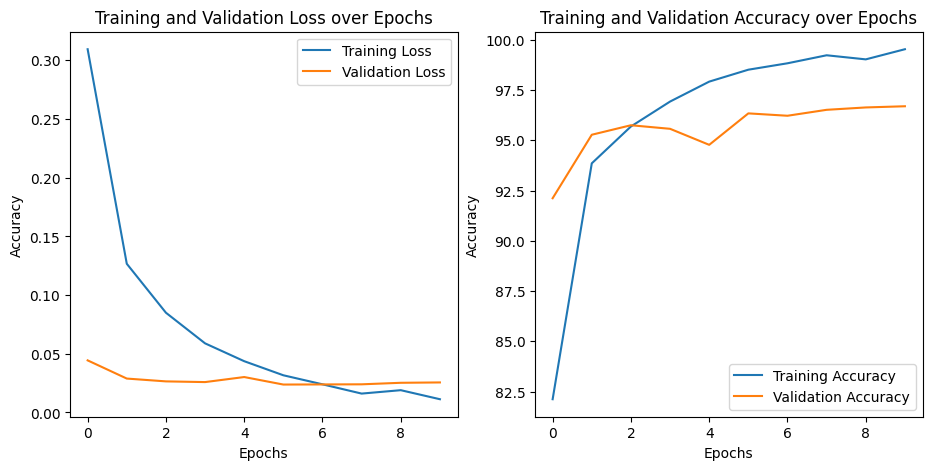

In [26]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11, 5))

axs[0].plot(total_loss_train_plot, label="Training Loss")
axs[0].plot(total_loss_val_plot, label="Validation Loss")
axs[0].set_title("Training and Validation Loss over Epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Accuracy")
axs[0].legend()


axs[1].plot(total_acc_train_plot, label="Training Accuracy")
axs[1].plot(total_acc_val_plot, label="Validation Accuracy")
axs[1].set_title("Training and Validation Accuracy over Epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].legend()


plt.show()

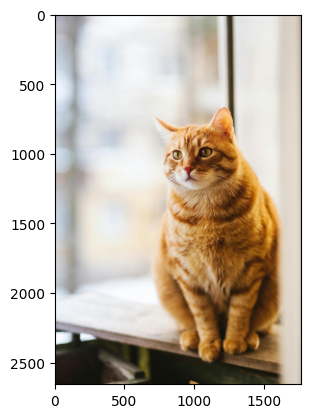


Prediction: 



array(['wild'], dtype=object)

In [35]:
# 1- read image
# 2- Transform using transform object
# 3- predict through the model
# 4- inverse transform by label encoder

def predict_image(image_path):
  image = Image.open(image_path).convert('RGB')
  image = transform(image).to(device)

  output = model(image.unsqueeze(0))
  output = torch.argmax(output, axis = 1).item()
  return label_encoder.inverse_transform([output])

## Visualize the image
image = Image.open("/content/pexels-kowalievska-1170986.jpg")
plt.imshow(image)
plt.show()


## Predict
print()
print("Prediction: \n")
predict_image("/content/pexels-kowalievska-1170986.jpg")